# CT5130: Reinforcement Learning – Assignment 2
## Alexey Shapovalov (20235952)
### 2022-04-10

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import Dict
import numpy as np
import random


random.seed(42)
np.random.seed(42)

### Part 1: Create the FrozenLake
* The game is configurable via the constructor, defaults being set to the assignment requirements.
* The `next_state` method returns what the next state would be if the given action is taken. However the state of the game is unchanged.
* The `move` method progresses the game by taking the given action.
* The game can be restarted with the `restart` method.
* The `reward` method returns the reward for the current state.
* The `is_end` method can be used to evaluate if the game has reached the terminal state.

In [2]:
class FrozenLake:
    def __init__(self, rows=5, cols=5, start=(0, 0), goal=(4, 4), holes=((1, 0), (1, 3), (3, 1), (4, 2))):
        self.rows = rows
        self.cols = cols
        self.goal = goal
        self.holes = holes
        self.start = start
        self.actions = [0, 1, 2, 3]  # up, down, left, right
        self.state = start

    def reward(self):
        if self.state == self.goal:
            return 10.0
        elif self.state in self.holes:
            return -5.0
        else:
            return -1.0

    def is_end(self):
        return self.state in self.holes + (self.goal, )

    def next_state(self, action):
        if action == 0:
            next_state = (self.state[0] - 1, self.state[1])
        elif action == 1:
            next_state = (self.state[0] + 1, self.state[1])
        elif action == 2:
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)

        if (next_state[0] >= 0) and (next_state[0] <= self.rows - 1):
            if (next_state[1] >= 0) and (next_state[1] <= self.cols - 1):
                return next_state  # if next state legal
        return self.state  # any move off the grid leaves state unchanged

    def move(self, action):
        self.state = self.next_state(action)

    def restart(self):
        self.state = self.start

### Part 2: Implement the Reinforcement Learning algorithm Q-learning
* The Q-learning algorithm is implemented via the Agent class. The hyperparameters are configurable through the constructor with the defaults being set to the assignment requirements.
* `max_value` returns the max Q value for the given state where as `max_action` returns the action that would yield the max Q value.
* `next_action` returns the next action to take via the epsilon greedy algorithm.
* `qlearn` runs the game for the given amount of episodes to learn the Q action values.
* `play` plays the game with the learned Q values and returns the board:
    * `x` represents locations the agent did not move to
    * `o` represents holes
    * `g` represents the goal
    * the numbers outline the sequence the agent took
* `Qmax` returns the max Q value for each state.

In [3]:
class Agent:
    def __init__(self, lake, alpha=0.5, gamma=0.9, epsilon=0.1):
        self.lake = lake
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialise Q:
        # {
        #    state: {action: 0.0, action1: 0.0, ...},
        #    state1: {action: 0.0, action1: 0.0, ...},
        #    ...
        # }
        self.Q: Dict[(int, int), Dict[int, float]] = defaultdict(lambda: {})
        for i in range(self.lake.rows):
            for j in range(self.lake.cols):
                for a in range(len(self.lake.actions)):
                    self.Q[(i, j)][a] = 0.0  # set initial value to 0, for Q(s,a)

    def max_value(self, state):
        return max(self.Q[state].items(), key=lambda x: x[1])[1]

    def max_action(self, state):
        return max(self.Q[state].items(), key=lambda x: x[1])[0]

    def next_action(self):
        # Epsilon greedy, based on: https://www.baeldung.com/cs/epsilon-greedy-q-learning
        if random.uniform(0, 1) < self.epsilon:
            return self.lake.actions[random.randint(0, len(self.lake.actions) - 1)]
        else:
            return self.max_action(self.lake.state)

    def qlearn(self, episodes):
        rewards = []
        steps = []

        for _ in range(episodes):
            episode_reward = 0
            episode_steps = 0

            while not self.lake.is_end():
                action = self.next_action()
                state = self.lake.state
                self.lake.move(action)
                episode_steps += 1
                next_state = self.lake.state
                reward = self.lake.reward()
                self.Q[state][action] = self.Q[state][action] + self.alpha * (reward + self.gamma * (self.max_value(next_state) - self.Q[state][action]))
                episode_reward += reward

            rewards.append(episode_reward)
            steps.append(episode_steps)
            self.lake.restart()

        return rewards, steps

    def play(self):
        states = defaultdict(lambda: 'x')
        for hole in self.lake.holes:
            states[hole] = 'o'
        states[self.lake.goal] = 'g'
        i = 0
        while not self.lake.is_end():
            state = self.lake.state
            states[state] = i
            action = self.max_action(state)
            self.lake.move(action)
            i += 1
        
        self.lake.restart()
        return np.array([
            [states[(i, j)] for j in range(self.lake.cols)] for i in range(self.lake.rows)
        ])

    def Qmax(self):
        return np.array([
            [self.max_value((i, j)) for j in range(self.lake.cols)] for i in range(self.lake.rows)
        ])

In [4]:
# Part 2: Run the frozen lake experiment for 10000 episodes.
lake = FrozenLake()
agent = Agent(lake)
episode_rewards, episode_steps = agent.qlearn(10000)

In [5]:
# Part 2: Output the action value estimates at the end of the learning process.
print(agent.Qmax())

[[ 3.33333333  4.44444444  5.55555556  4.0863506  -0.16828481]
 [ 0.          5.55555556  6.66666667  0.          5.75464805]
 [ 5.55555556  6.66666667  7.77777778  8.88888889 10.        ]
 [ 2.44720543  0.          8.88888889 10.         11.11111111]
 [-2.4668125  -2.5         0.         11.11111111  0.        ]]


In [6]:
print(agent.play())

[['0' '1' 'x' 'x' 'x']
 ['o' '2' 'x' 'o' 'x']
 ['x' '3' '4' 'x' 'x']
 ['x' 'o' '5' '6' 'x']
 ['x' 'x' 'o' '7' 'g']]


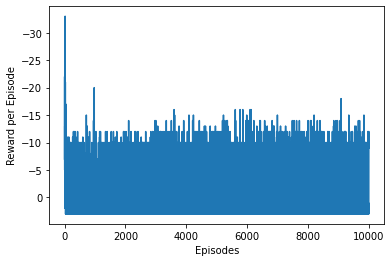

In [7]:
# Part 2: Plot a curve of the reward per episode (similar to what was depicted in the slides for the cliff walking task Q-learning vs SARSA). 
plt.gca().invert_yaxis()
plt.plot(range(len(episode_rewards)), episode_rewards)
plt.xlabel("Episodes")
plt.ylabel("Reward per Episode")
plt.show()

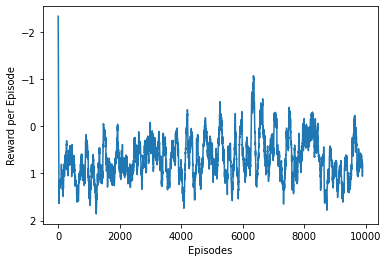

In [8]:
# Plot the running average over a window of N
# Based on: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
N = 100
smoothed = np.convolve(episode_rewards, np.ones(N)/N, mode='valid')
plt.gca().invert_yaxis()
plt.plot(range(len(smoothed)), smoothed)
plt.xlabel("Episodes")
plt.ylabel("Reward per Episode")
plt.show()

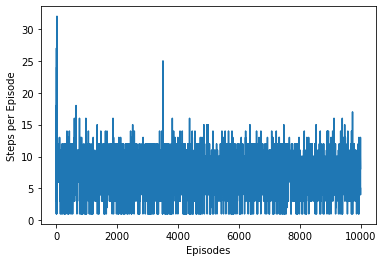

In [9]:
plt.plot(range(len(episode_steps)), episode_steps)
plt.xlabel("Episodes")
plt.ylabel("Steps per Episode")
plt.show()

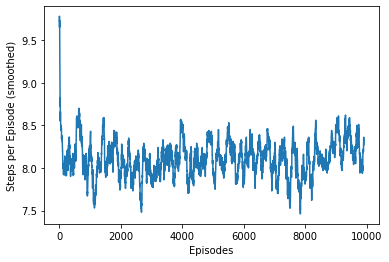

In [10]:
# Plot the running average over a window of N
# Based on: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
N = 100
smoothed = np.convolve(episode_steps, np.ones(N)/N, mode='valid')
plt.plot(range(len(smoothed)), smoothed)
plt.xlabel("Episodes")
plt.ylabel("Steps per Episode (smoothed)")
plt.show()

# References

* Enda Barret's Lecture Notes for Reinforcement Learning CT5134, National University of Ireland, Galway, 2022.
    * Code was adapted from the examples of this module.